# [Training VGG11 from Scratch using PyTorch](https://debuggercafe.com/training-vgg11-from-scratch-using-pytorch/)
![](https://debuggercafe.com/wp-content/uploads/2021/04/Training-VGG11-from-Scratch-using-PyTorch-e1619013637241.jpg)

## Download the Input Data

In [ ]:
import requests
url = "https://drive.google.com/uc?id=1H0pHhC3BHpqMML4a5n79hxXwo047KcrM&export=download"
r = requests.get(url)
with open('input.zip', 'wb') as f:
   f.write(r.content)

In [ ]:
# extract the input test data 
!unzip input.zip

Archive:  input.zip
   creating: input/
   creating: input/test_data/
  inflating: input/test_data/eight.jpg  
  inflating: input/test_data/two.jpg  
  inflating: input/test_data/zero.jpg  


In [ ]:
!mkdir src
!mkdir outputs

In [ ]:
%cd src

/content/src


In [ ]:
%%writefile models.py
import torch.nn as nn

# the VGG11 architecture
class VGG11(nn.Module):
    def __init__(self, in_channels, num_classes=1000):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Writing models.py


In [ ]:
%%writefile train.py
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from models import VGG11

matplotlib.style.use('ggplot')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")
epochs = 3 # epochs = 10
batch_size = 32

# our transforms will differ a bit from the VGG paper
# as we are using the MNIST dataset, so, we will directly resize...
# ... the images to 224x224 and not crop them and we will not use...
# ... any random flippings also
train_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5), std=(0.5))])
valid_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5), std=(0.5))])

# training dataset and data loader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                             download=True, 
                                             transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               shuffle=True)
# validation dataset and dataloader
valid_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=True, 
                                           transform=valid_transform)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                             batch_size=batch_size,
                                             shuffle=False)

# instantiate the model
model = VGG11(in_channels=1, num_classes=10).to(device)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function
criterion = nn.CrossEntropyLoss()
# the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, 
                      weight_decay=0.0005)

# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1

        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# validation
def validate(model, testloader, criterion):
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

            # calculate the accuracy for each class
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    # print the accuracy for each class after evey epoch
    # the values should increase as the training goes on
    print('\n')
    for i in range(10):
        print(f"Accuracy of digit {i}: {100*class_correct[i]/class_total[i]}")

    return epoch_loss, epoch_acc

# start the training
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, 
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_dataloader,  
                                                 criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print('\n')
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

    print('-'*50)

# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, '../outputs/model.pth')

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../outputs/accuracy.jpg')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss.jpg')
plt.show()
 
print('TRAINING COMPLETE')

Overwriting train.py


In [ ]:
!python train.py

[INFO]: Computation device: cuda
[INFO]: 128,806,154 total parameters.
[INFO]: 128,806,154 trainable parameters.
[INFO]: Epoch 1 of 3
Training
100% 1875/1875 [16:05<00:00,  1.94it/s]
Validation
100% 313/313 [00:52<00:00,  5.95it/s]


Accuracy of digit 0: 98.46938775510205
Accuracy of digit 1: 99.55947136563877
Accuracy of digit 2: 93.8953488372093
Accuracy of digit 3: 91.68316831683168
Accuracy of digit 4: 94.29735234215886
Accuracy of digit 5: 94.61883408071749
Accuracy of digit 6: 98.01670146137788
Accuracy of digit 7: 96.49805447470817
Accuracy of digit 8: 88.91170431211499
Accuracy of digit 9: 95.34192269573836


Training loss: 1.970, training acc: 24.767
Validation loss: 0.179, validation acc: 95.190
--------------------------------------------------
[INFO]: Epoch 2 of 3
Training
100% 1875/1875 [16:01<00:00,  1.95it/s]
Validation
100% 313/313 [00:52<00:00,  5.94it/s]


Accuracy of digit 0: 99.6938775510204
Accuracy of digit 1: 99.8237885462555
Accuracy of digit 2: 99.3217054263565

In [ ]:
# [INFO]: Computation device: cuda
# Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
# Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz
# 9913344it [00:00, 65470990.28it/s]                 
# Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

# Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
# Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz
# 29696it [00:00, 61599432.04it/s]
# Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

# Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
# Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
# 1649664it [00:00, 23772473.33it/s]
# Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

# Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
# Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
# 5120it [00:00, 21136650.08it/s]
# Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

# [INFO]: 128,806,154 total parameters.
# [INFO]: 128,806,154 trainable parameters.
# [INFO]: Epoch 1 of 10
# Training
# 100% 1875/1875 [16:04<00:00,  1.94it/s]
# Validation
# 100% 313/313 [00:52<00:00,  5.93it/s]


# Accuracy of digit 0: 0.0
# Accuracy of digit 1: 0.0
# Accuracy of digit 2: 100.0
# Accuracy of digit 3: 0.0
# Accuracy of digit 4: 0.0
# Accuracy of digit 5: 0.0
# Accuracy of digit 6: 0.0
# Accuracy of digit 7: 0.0
# Accuracy of digit 8: 0.0
# Accuracy of digit 9: 0.0


# Training loss: 2.301, training acc: 11.378
# Validation loss: 2.302, validation acc: 10.320
# --------------------------------------------------
# [INFO]: Epoch 2 of 10
# Training
# 100% 1875/1875 [15:55<00:00,  1.96it/s]
# Validation
# 100% 313/313 [00:52<00:00,  5.94it/s]


# Accuracy of digit 0: 98.6734693877551
# Accuracy of digit 1: 99.8237885462555
# Accuracy of digit 2: 99.4186046511628
# Accuracy of digit 3: 98.11881188118812
# Accuracy of digit 4: 98.57433808553971
# Accuracy of digit 5: 98.54260089686099
# Accuracy of digit 6: 98.95615866388309
# Accuracy of digit 7: 98.73540856031128
# Accuracy of digit 8: 97.84394250513347
# Accuracy of digit 9: 96.72943508424183


# Training loss: 0.362, training acc: 87.442
# Validation loss: 0.047, validation acc: 98.560
# --------------------------------------------------
# [INFO]: Epoch 3 of 10
# Training
# 100% 1875/1875 [15:56<00:00,  1.96it/s]
# Validation
# 100% 313/313 [00:52<00:00,  5.94it/s]


# Accuracy of digit 0: 99.79591836734694
# Accuracy of digit 1: 98.32599118942731
# Accuracy of digit 2: 99.03100775193798
# Accuracy of digit 3: 99.60396039603961
# Accuracy of digit 4: 97.45417515274949
# Accuracy of digit 5: 97.98206278026906
# Accuracy of digit 6: 98.74739039665971
# Accuracy of digit 7: 99.12451361867704
# Accuracy of digit 8: 99.48665297741273
# Accuracy of digit 9: 97.62140733399406


# Training loss: 0.061, training acc: 98.265
# Validation loss: 0.040, validation acc: 98.720

In [ ]:
%%writefile test.py
import torch
import cv2
import glob as glob
import torchvision.transforms as transforms
import numpy as np

from models import VGG11

# inferencing on CPU
device = 'cpu'
# initialize the VGG11 model
model = VGG11(in_channels=1, num_classes=10)
# load the model checkpoint
checkpoint = torch.load('../outputs/model.pth')
# load the trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# simple image transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

# get all the test images path
image_paths = glob.glob('../input/test_data/*.jpg')

for i, image_path in enumerate(image_paths):
    orig_img = cv2.imread(image_path)
    # convert to grayscale to make the image single channel
    image = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    image = transform(image)
    # add one extra batch dimension
    image = image.unsqueeze(0).to(device)
    # forward pass the image through the model
    outputs = model(image)
    # get the index of the highest score
    # the highest scoring indicates the label for the Digit MNIST dataset
    label = np.array(outputs.detach()).argmax()
    print(f"{image_path.split('/')[-1].split('.')[0]}: {label}")
    # put the predicted label on the original image
    cv2.putText(orig_img, str(label), (15, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                2, (0, 255, 0), 2)
    # show and save the resutls
    # cv2.imshow('Result', orig_img)
    # cv2.waitKey(0)
    cv2.imwrite(f"../outputs/result_{i}.jpg", orig_img)

Overwriting test.py


In [ ]:
!python test.py

two: 2
zero: 0
eight: 8


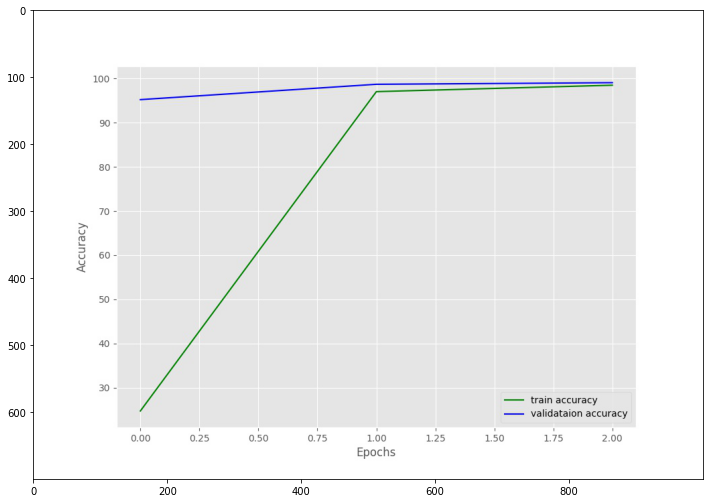

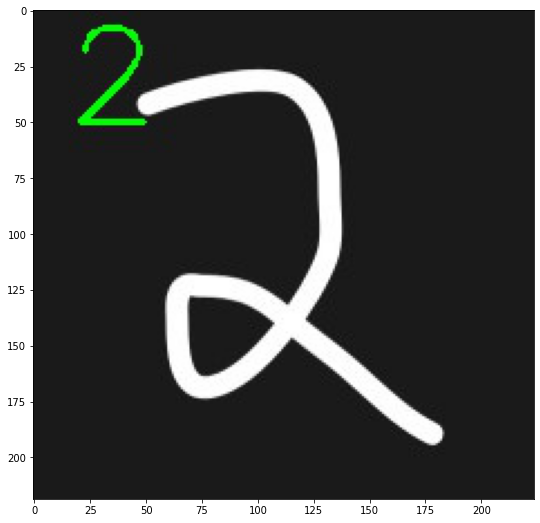

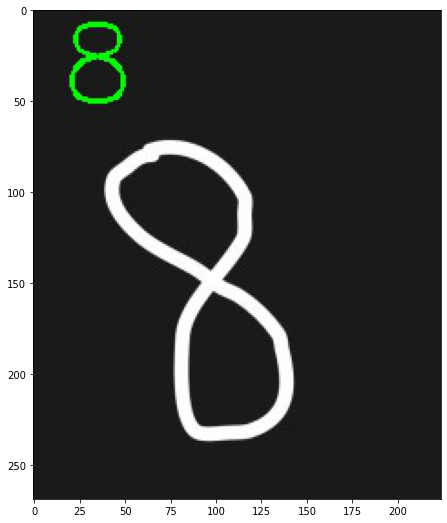

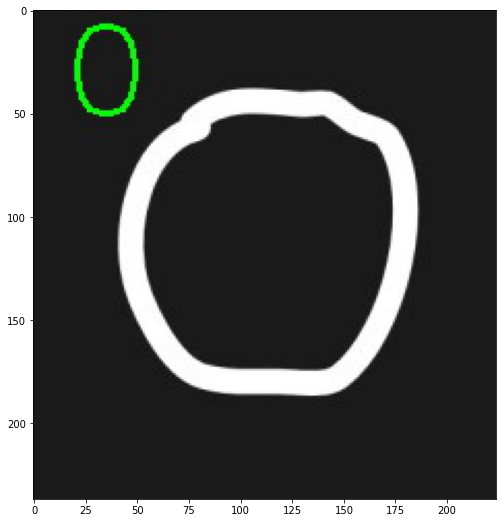

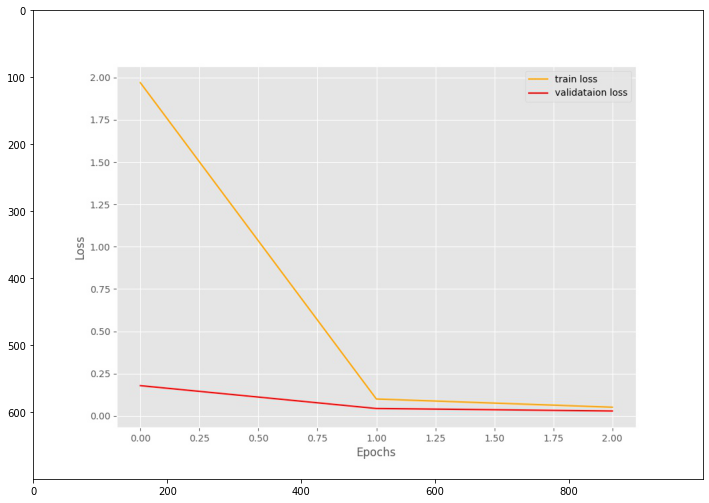

In [ ]:
# visualize the results
import matplotlib.pyplot as plt
import matplotlib
import glob as glob

matplotlib.rcParams['figure.figsize'] = 12, 9

image_paths = glob.glob('../outputs/*.jpg')

for image_path in image_paths:
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.show()